# Домашнее задание №4

Задание присылать на почту **aleksartmonov@gmail.com** в форматах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **AU2018 HW4 <Фамилия Имя>**

soft deadline: 8.04.2018T23:59:00+0300

hard deadline: 15.04.2018T23:59:00+0300


### Поиск изображений по содержанию (30 баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

4. Релизуйте функцию `retrieve` и сделайте 1000 запросов изображениями из файла **test.dat**.

5. Продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  
    
6. Для каждого запроса нужно оценить APk, где k=10 и посчитать среднее значение этой величины по всем запросам (MAPk).

Также за это задание можно получить еще до 20-ти дополнительных баллов. Качество поиска вы посчитаете сами, а вот со скоростью есть некоторые трудности, реализуйте ваше решение таким образом, чтобы я мог из командной строки вызвать:

`python cbir.py --retrieve /path/to/image`

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в борьбе за 10 призовых баллов. Первое место получает 10 баллов и шоколадку, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки. И помните о том, что время поиска очень важный параметр.

Удачи!


In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
import gist # descriptor = gist.extract(img)

from tqdm import tqdm
from sklearn.cluster import KMeans

# ! pip install lshash3 --upgrade
from lshash.lshash import LSHash

NUM = 100

%matplotlib inline

In [2]:
def desc_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 0]
    h, w = hsv.shape
    
    clr_hist = np.histogram(hsv.flatten(), bins=90)[0] / (w * h)
    
    mean = np.zeros((4,))
    std = np.zeros((4,))

    hhalf = h // 2
    whalf = w // 2

    for i in range(4):
        mean[i] = np.mean(hsv[(i // 2) * hhalf : (i // 2 + 1) * hhalf, (i % 2) * whalf : (i % 2 + 1) * whalf])
        std[i] = np.std(hsv[(i // 2) * hhalf : (i // 2 + 1) * hhalf, (i % 2) * whalf : (i % 2 + 1) * whalf])
        
    return np.hstack((clr_hist, mean, std))

In [3]:
def desc_gist(img):
    return gist.extract(img)

In [4]:
test_ind = []
test_lbl = []

with open('test.dat') as f:
    for line in f:
        ind = int(line[:-6])
        test_ind.append(ind)
        test_lbl.append((ind - 1) // NUM)

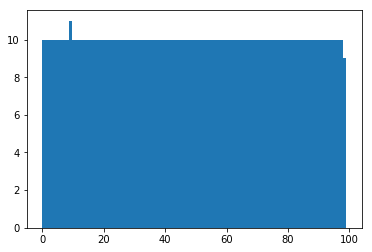

In [5]:
plt.hist(test_lbl, bins=NUM);

In [6]:
train_ind = []
train_lbl = []

for i in tqdm(range(1, 10001)):
    if i not in test_ind:
        train_ind.append(i)
        train_lbl.append((i - 1) // NUM)

100%|██████████| 10000/10000 [00:00<00:00, 30939.43it/s]


In [7]:
class Retriever:
    def __init__(self, get_desc):
        self.desc = get_desc
    
    
    def gen_data(self, from_file=True, filename=None, ids=None):
        if from_file:
            self.data = np.load(filename)
        else:
            X = []

            for i in tqdm(ids):
                img = cv2.imread('Corel/' + str(i) + '.jpg')
                X.append(self.desc(img))

            X = np.array(X)
            np.save(filename, X)
            self.data = X
        
        self.divider = np.std(self.data, axis=0)
        self.data /= self.divider
            
    def clusterize(self, train_lbl, with_centers=True):

        if with_centers:

            centers = []
            for i in np.unique(train_lbl):
                centers.append(np.mean(self.data[train_lbl == i], axis=0))
            centers = np.array(centers)

        else:
            centers = 'k-means++'

        model = KMeans(n_clusters=NUM, n_jobs=-1, random_state=0, init=centers, n_init=1)
        pred_lbl = model.fit_predict(self.data)

        score = 0

        for i in np.unique(train_lbl):
            labels, counts = np.unique(pred_lbl[train_lbl == i], return_counts=True)
            score += np.max(counts) / np.sum(train_lbl == i)

        print('Clusterization score: ', score / NUM)

        self.clust_model = model
        self.clust_labels = pred_lbl
        
        
    def lsh_clusters(self, lsh_len):
        lsh = np.zeros(shape=(NUM,), dtype=LSHash)
        mapping = np.zeros(shape=(NUM,), dtype=dict)

        for i in range(NUM):
            lsh[i] = LSHash(lsh_len, self.data.shape[1])
            mapping[i] = {}

        for i in tqdm(range(self.data.shape[0])):
            instance = self.data[i]
            lbl = self.clust_labels[i]

            lsh[lbl].index(instance)
            mapping[lbl][tuple(instance)] = i

        self.lsh = lsh
        self.mapping = mapping
        
        
    def retrieve(self, index, train_lbl, train_ind, show=False, k=10):
        img = cv2.imread('Corel/' + str(index) + '.jpg')
        
        if show:
            self.show(img)
        
        img_lbl = (index - 1) // 100
        features = self.desc(img) / self.divider
        lbl = self.clust_model.predict(features[np.newaxis, :])[0]
        res = self.lsh[lbl].query(features, num_results=k)

        score = 0
        relevant = 0
        
        for i, (instance, _) in enumerate(res):
            res_ind = self.mapping[lbl][instance]
            res_lbl = train_lbl[res_ind]
            
            if res_lbl == img_lbl:
                relevant += 1
                score += relevant / (i + 1)
            
            if show:
                self.show(cv2.imread('Corel/' + str(train_ind[res_ind]) + '.jpg'))
            
        return score / k
    
    
    def show(self, img, size=5):
        plt.figure(figsize=(size,size))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [8]:
retr = Retriever(desc_gist)

In [9]:
retr.gen_data(from_file=True, filename='gist_train.npy')

In [11]:
retr.clusterize(train_lbl=train_lbl, with_centers=True)

Clusterization score:  0.25276334526896327


In [12]:
retr.lsh_clusters(lsh_len=2)

100%|██████████| 9000/9000 [00:02<00:00, 3061.35it/s]


In [13]:
scores = []

for i in tqdm(test_ind):
    scores.append(retr.retrieve(i, train_lbl=train_lbl, train_ind=train_ind, show=False))
    
scores = np.array(scores)

100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


Время: примерно 0.2 секунды.

In [14]:
scores.mean()

0.19405773809523807

In [24]:
np.random.choice(test_ind, 5)

array([7789, 1836, 5147, 8123, 3342])

0.32666666666666666

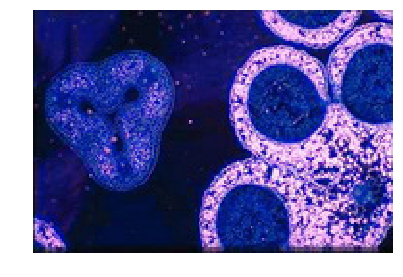

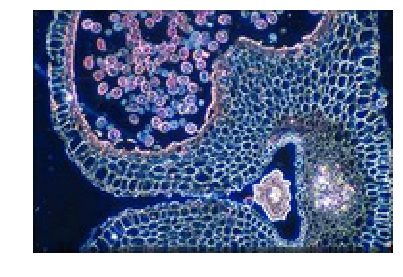

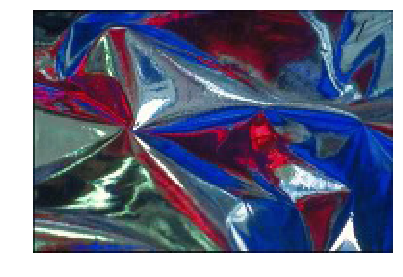

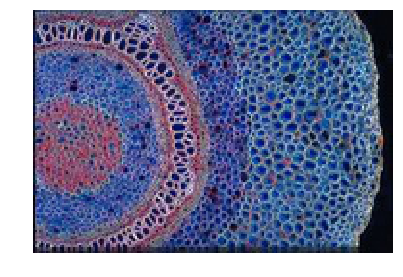

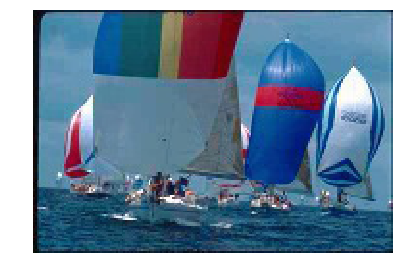

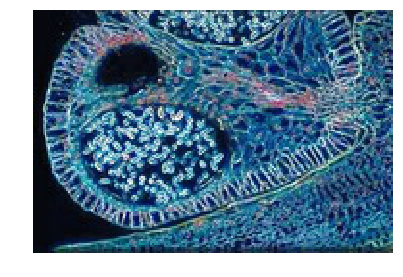

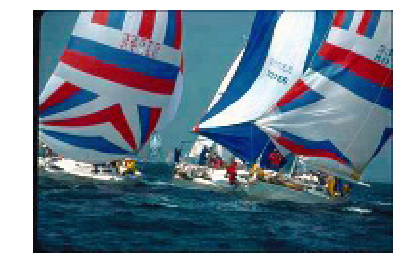

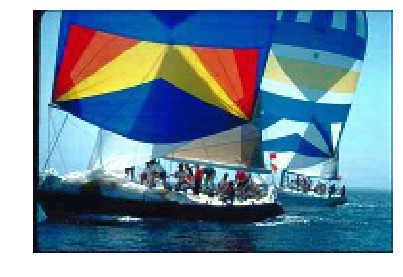

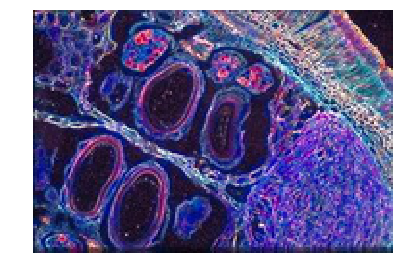

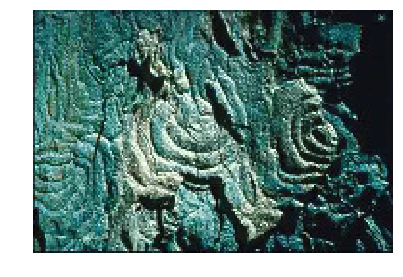

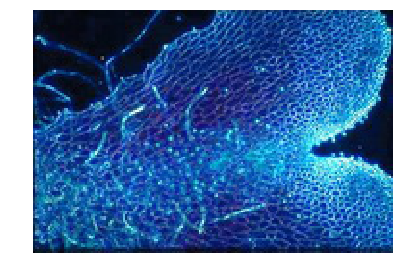

In [25]:
retr.retrieve(7789, train_lbl=train_lbl, train_ind=train_ind, show=True)

0.8

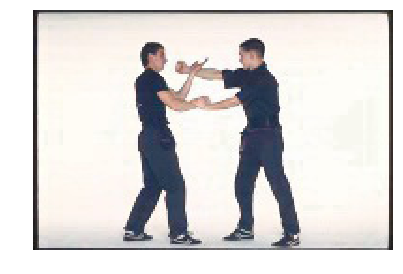

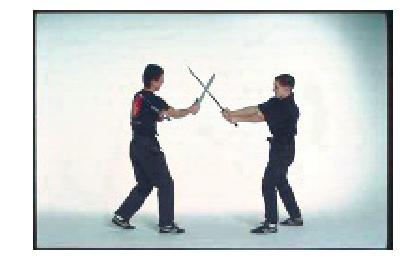

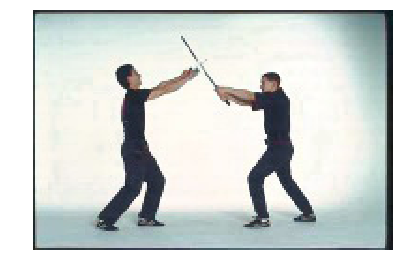

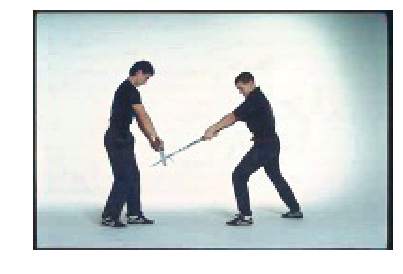

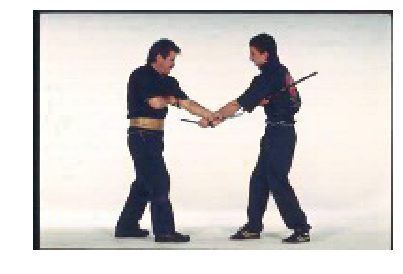

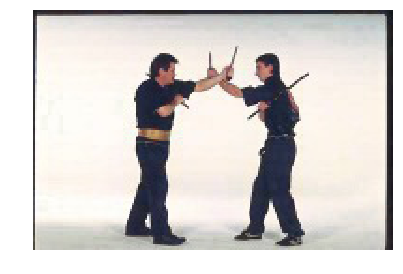

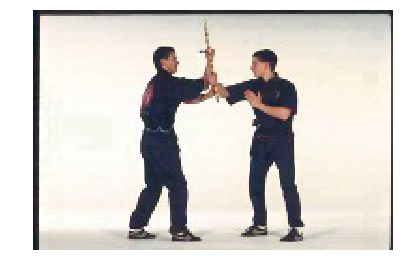

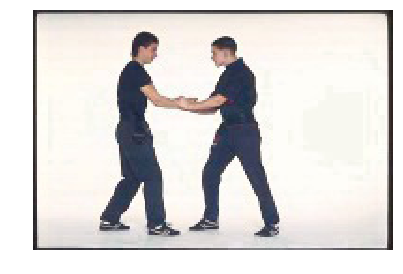

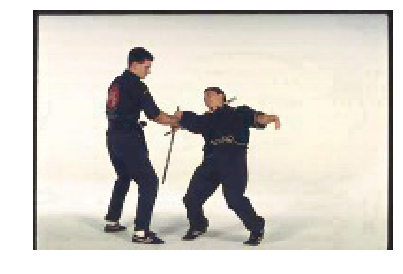

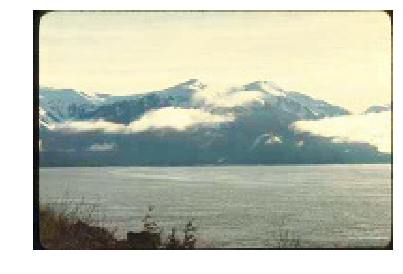

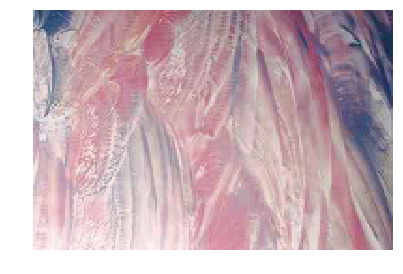

In [26]:
retr.retrieve(1836, train_lbl=train_lbl, train_ind=train_ind, show=True)

0.4

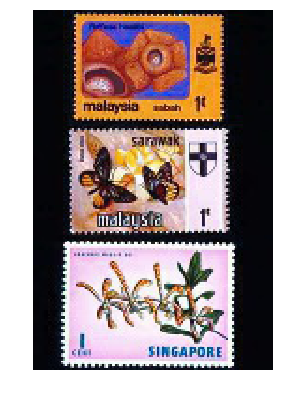

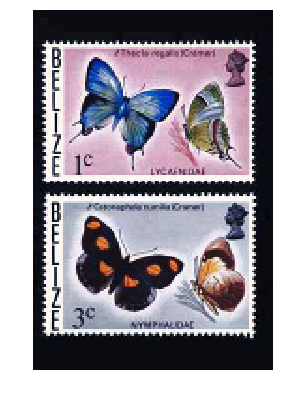

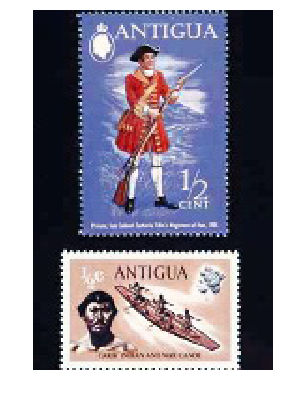

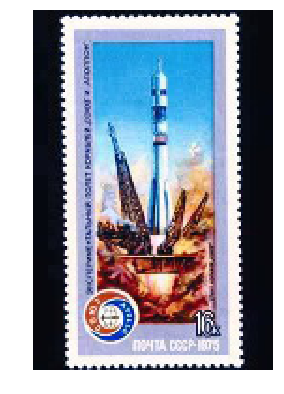

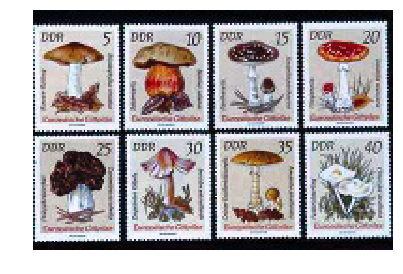

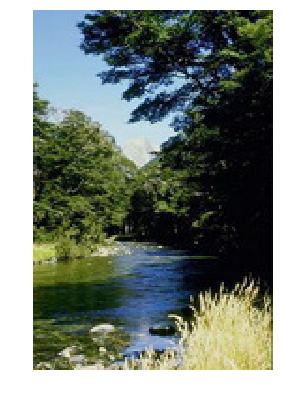

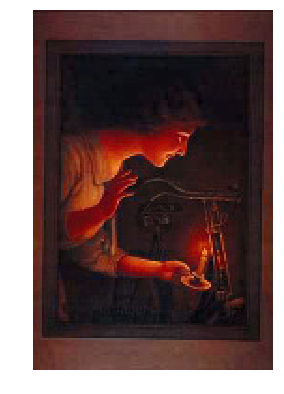

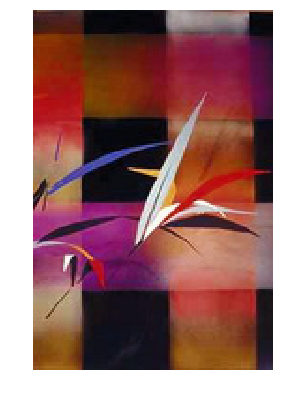

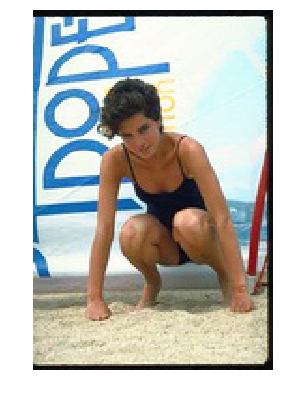

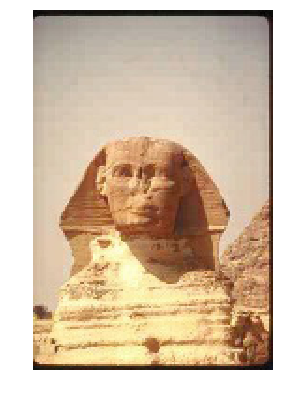

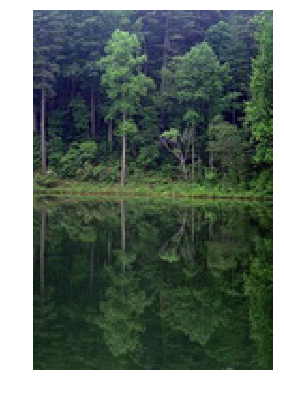

In [27]:
retr.retrieve(5147, train_lbl=train_lbl, train_ind=train_ind, show=True)

0.5233333333333332

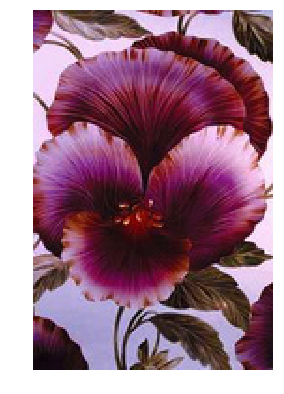

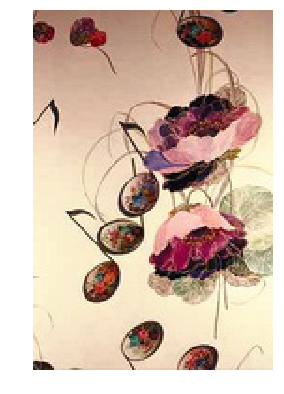

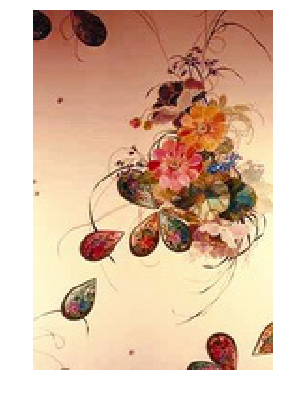

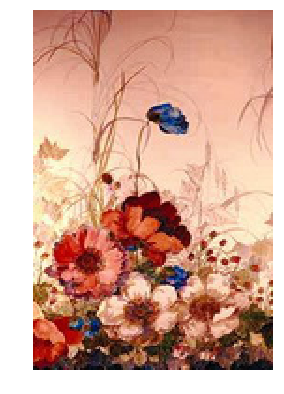

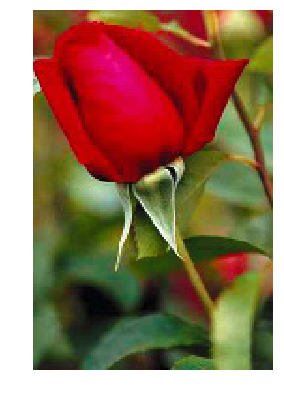

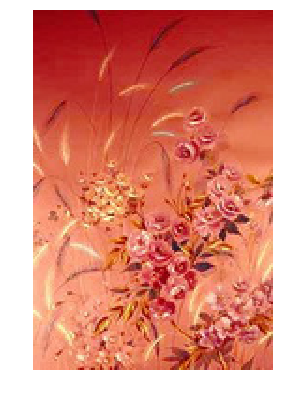

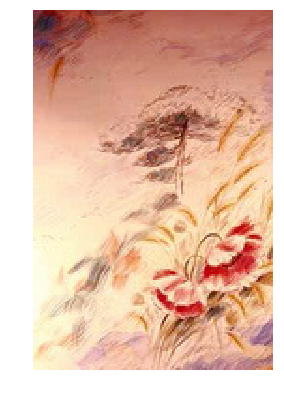

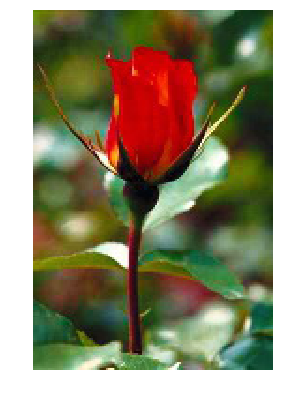

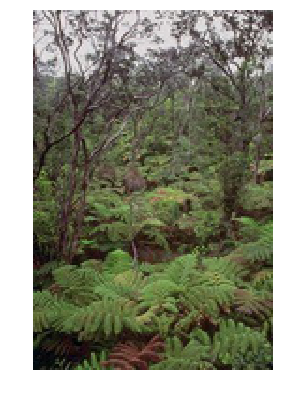

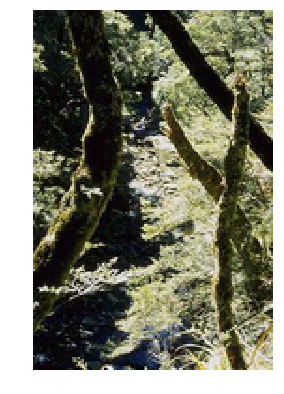

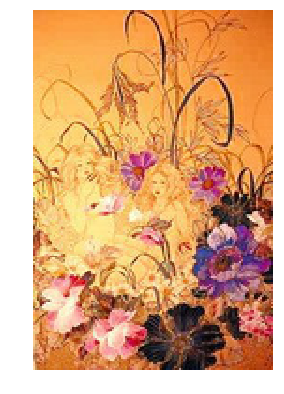

In [28]:
retr.retrieve(8123, train_lbl=train_lbl, train_ind=train_ind, show=True)

0.36666666666666664

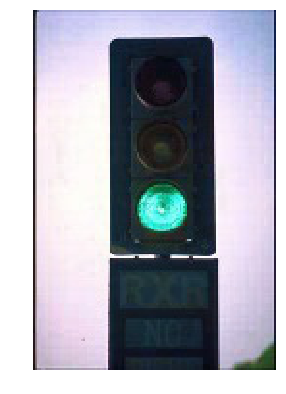

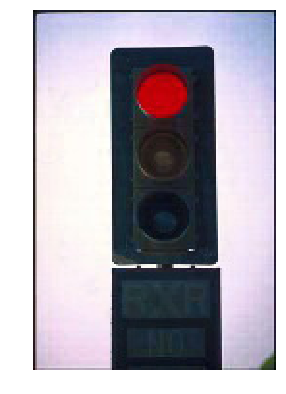

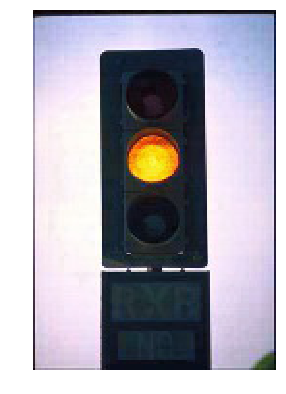

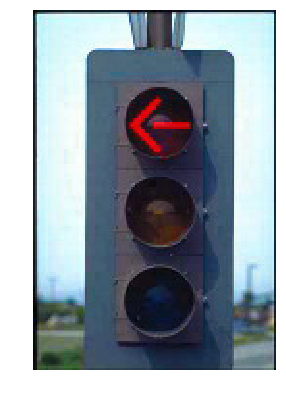

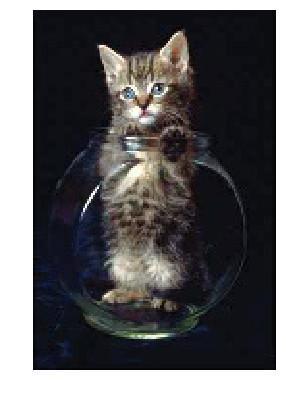

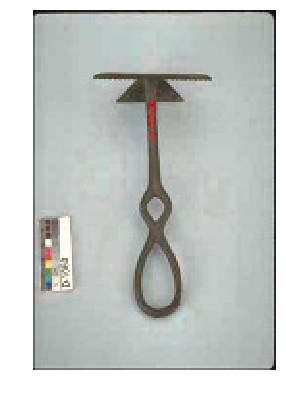

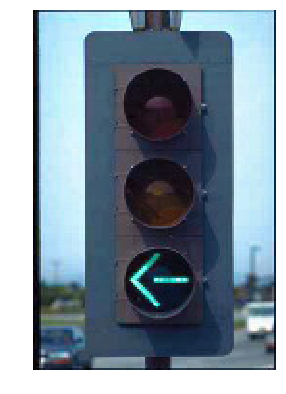

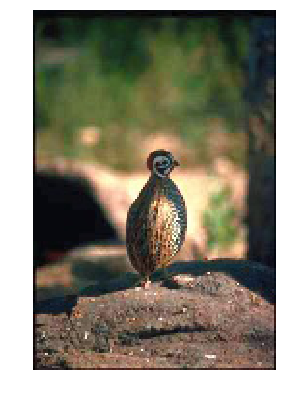

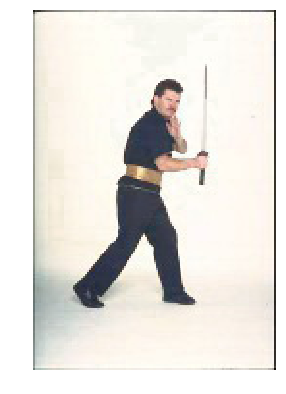

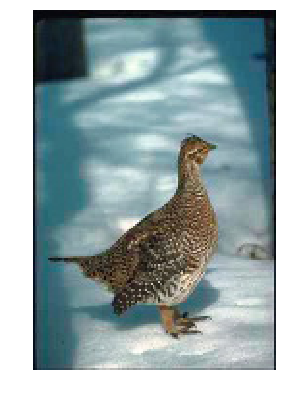

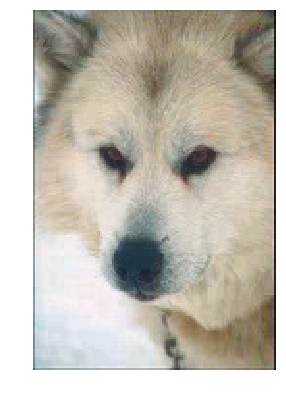

In [29]:
retr.retrieve(3342, train_lbl=train_lbl, train_ind=train_ind, show=True)